In [1]:
# open this to install all the required packages
#!pip install opencv-python matplotlib imageio gdown tensorflow wordninja python-Levenshtein levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 8.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.0 MB/s eta 0:00:0000:01
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=7c4f31a6bd839a729c6b1ce5d546d45c7ef41ad8c0d1b72e7e13361c32b92fd7
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


# 1. Import Required Libraries

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import zipfile
from tensorflow.keras.callbacks import LearningRateScheduler ,ModelCheckpoint ,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten, Input
from Levenshtein import distance as levenshtein_distance
import wordninja

# 2. Use GPu

In [3]:
tf.debugging.set_log_device_placement(False)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available!")
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("No GPU found. Using CPU.")

GPU is available!
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.list_physical_devices('GPU')
# print(f"Available GPUs: {gpus}")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

In [6]:
import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 
tf.get_logger().setLevel("ERROR")  


# 3. download and prepare data

In [7]:
dataset_url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output_file = 'lip_data.zip'
gdown.download(dataset_url, output_file, quiet=False)
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('lip_data')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=f64715b7-ffd3-40b9-b953-11c8ada901dd
To: /kaggle/working/lip_data.zip
100%|██████████| 423M/423M [00:03<00:00, 140MB/s]  


# 4. data preprocessing

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_index = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
print(f"Vocabulary size: {char_to_index.vocabulary_size()}")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_index.get_vocabulary(),
    invert=True, 
    oov_token=""
)

Vocabulary size: 40


In [9]:
def extract_mouth_region(video_path: str) -> np.ndarray:
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mouth_region = gray_frame[180:240, 80:220]
        frames.append(mouth_region)
    cap.release()
    # print(frames)
    
    if len(frames)>75 :
        frames = frames[:75]
    else:
        frames.extend([frames[-1]] * (75-len(frames)))
    frames = np.array(frames, dtype=np.float32)
    frames = (frames-np.mean(frames)) / np.std(frames)
    # print(frames)
    # print("------------------------sam--------------")
    # print(len(frames))
    return np.expand_dims(frames, axis=-1)

In [10]:
def load_transcription(transcription_path: str) ->  tf.Tensor:

    with open(transcription_path, 'r') as file:
        lines = file.readlines()
    tokens = []
    for line in lines:
        parts = line.split()
        if parts[2] != 'sil':  
            tokens.extend(list(parts[2]))  
    return char_to_index(tf.constant(tokens))

In [11]:
def load_lip_data_with_augmentation(file_path: str):
    file_path = bytes.decode(file_path.numpy())
    file_name = file_path.split('/')[-1].split('.')[0] 
    video_file = os.path.join('/kaggle/working/lip_data/data/s1', f'{file_name}.mpg')
    transcription_file = os.path.join('/kaggle/working/lip_data/data/alignments/s1', f'{file_name}.align')
    video_frames = extract_mouth_region(video_file)
    transcription = load_transcription(transcription_file)
    # print(file_path)
    # print("-----------------------")
    # print(file_name)
    # print("------------------------")
    # print(len(video_frames))

    if np.random.rand()>0.5:
        video_frames = np.flip(video_frames, axis=2)  
    return video_frames, transcription

In [12]:
def map_data_with_augmentation(file_path: str):
    result = tf.py_function(load_lip_data_with_augmentation, [file_path], (tf.float32, tf.int64))
    return result

In [13]:
lip_dataset = tf.data.Dataset.list_files('/kaggle/working/lip_data/data/s1/*.mpg', shuffle=False)
lip_dataset = lip_dataset.shuffle(500, reshuffle_each_iteration=False)
lip_dataset = lip_dataset.map(map_data_with_augmentation)
lip_dataset = lip_dataset.padded_batch(2, padded_shapes=([75, 60, 140, 1], [40]))
lip_dataset = lip_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
print(lip_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, 60, 140, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


In [15]:
sample = lip_dataset.as_numpy_iterator()

In [16]:
val = sample.next()

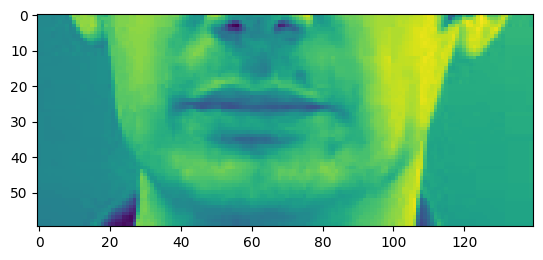

In [17]:
plt.imshow(val[0][1][-1])

In [18]:
decoded_continuous = tf.strings.reduce_join(
    [num_to_char(token) for token in val[1][0]],
    separator='' 
).numpy().decode('utf-8')

print("Continuous decoded text:", decoded_continuous)
segmented_words = wordninja.split(decoded_continuous)
decoded_text_with_spaces = ' '.join(segmented_words)

print("Segmented text:", decoded_text_with_spaces)


Continuous decoded text: binblueinrsevensoon
Segmented text: bin blue in r seven soon


In [19]:
%%capture
train_data = lip_dataset.take(350)
test_data = lip_dataset.skip(300).take(50)

In [20]:
print(len(train_data))
print("-------------------------")
print(len(test_data))

350
-------------------------
50


In [21]:
def custom_ctc_loss(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_size, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_size, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# 5. define the model

In [23]:
%%capture
lip_model = Sequential()
lip_model.add(Input(shape=(75, 60, 140, 1)))  
lip_model.add(Conv3D(32, (3, 3, 3), padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1, 2, 2)))
lip_model.add(Conv3D(64, (3, 3, 3), padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1, 2, 2)))
lip_model.add(Conv3D(128, (3, 3, 3), padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1, 2, 2)))
lip_model.add(TimeDistributed(Flatten()))
lip_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lip_model.add(Dropout(0.5))
lip_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lip_model.add(Dropout(0.5))
lip_model.add(Dense(char_to_index.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


# 6. compile the model

In [24]:
optimizer = Adam(learning_rate=0.0001)
lip_model.compile(optimizer=optimizer, loss=custom_ctc_loss)

In [25]:
lip_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 60, 140, 32)     │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 60, 140, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 30, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 30, 70, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 30, 70, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 15, 35, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 15, 35, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 15, 35, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 7, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 15232)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │      15,729,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,412,009 (62.61 MB)

 Trainable params: 16,412,009 (62.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
chek = lip_model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [27]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(chek[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttaaaaaaaaa'>

In [28]:
print("Input shape:", lip_model.input_shape)
print("Output shape:", lip_model.output_shape)

Input shape: (None, 75, 60, 140, 1)
Output shape: (None, 75, 41)


In [29]:
def lr_scheduler(epoch, lr):
    if epoch < 25:
        return lr  
    else:
        return float(lr * 0.95)        
schedule_callback = LearningRateScheduler(lr_scheduler)

In [30]:
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoint.weights.h5',  
    monitor='val_loss',                        
    save_best_only=True,                       
    save_weights_only=True,                     
    verbose=1                                   
)

In [31]:
def calculate_wer(y_true, y_pred, decoder):

    wer_scores = []
    for i in range(len(y_true)):
        true_text = tf.strings.reduce_join(num_to_char(y_true[i])).numpy().decode('utf-8')
        decoded = decoder(y_pred[i:i+1])[0]
        wer_scores.append(levenshtein_distance(true_text.split(), decoded.split()) / len(true_text.split()))
    return np.mean(wer_scores)

def ctc_decoder():
    def decoder(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = tf.keras.backend.ctc_decode(pred, 
                                            input_length=input_len,
                                            greedy=True)[0][0]
        texts = []
        for res in results:
            res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
            texts.append(res)
        return texts
    return decoder

In [32]:
class PrintLRCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch + 1}: Learning Rate = {lr}")

In [33]:
!nvidia-smi

Sun Feb  2 20:39:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             36W /   70W |    1283MiB /  15360MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
for x, y in train_data.take(1):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)

Input shape: (2, 75, 60, 140, 1)
Output shape: (2, 40)


# 7. train the model

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True,  
    verbose=1
)

In [36]:
history = lip_model.fit(
    train_data,
    validation_data=test_data,
    epochs=100,
    
    callbacks=[
        checkpoint_callback,
        schedule_callback,
        PrintLRCallback(),
        early_stopping,
    ]
)

Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 100.6755
Epoch 1: val_loss improved from inf to 66.91669, saving model to checkpoint.weights.h5
Epoch 1: Learning Rate = 9.999999747378752e-05
350/350 ━━━━━━━━━━━━━━━━━━━━ 111s 292ms/step - loss: 100.6254 - val_loss: 66.9167 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 69.4772
Epoch 2: val_loss improved from 66.91669 to 63.58356, saving model to checkpoint.weights.h5
Epoch 2: Learning Rate = 9.999999747378752e-05
350/350 ━━━━━━━━━━━━━━━━━━━━ 101s 289ms/step - loss: 69.4748 - val_loss: 63.5836 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 66.1835
Epoch 3: val_loss improved from 63.58356 to 62.23447, saving model to checkpoint.weights.h5
Epoch 3: Learning Rate = 9.999999747378752e-05
350/350 ━━━━━━━━━━━━━━━━━━━━ 101s 290ms/step - loss: 66.1831 - val_loss: 62.2345 - learning_rate: 1.0000e-04
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 18

# 8. evaluate the model

In [37]:
def calculate_cer(y_true, y_pred, decoder):
    cer_scores = []
    for i in range(len(y_true)):
        true_text = tf.strings.reduce_join(num_to_char(y_true[i])).numpy().decode('utf-8')
        decoded = decoder(y_pred[i:i+1])[0]
        cer_scores.append(levenshtein_distance(true_text, decoded) / len(true_text))
    return np.mean(cer_scores)

In [38]:
decoder = ctc_decoder()

y_true_list = []
y_pred_list = []

for x_batch, y_batch in test_data:
    preds = lip_model.predict(x_batch)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(preds)

y_true_all = np.concatenate(y_true_list, axis=0)
y_pred_all = np.concatenate(y_pred_list, axis=0)

cer_score = calculate_cer(y_true_all, y_pred_all, decoder)
print(f"Character Error Rate (CER): {cer_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [39]:
print(f"Accurcy : {1.0- cer_score:.4f}")


Accurcy : 0.7366


# 9. predict the model on batch and video

In [41]:
lip_model.load_weights('/kaggle/working/checkpoint.weights.h5')
test_data_n = test_data.as_numpy_iterator()

In [58]:
ex = test_data_n.next()
inputs_batch, targets_batch = ex[0], ex[1]

In [60]:
pred = lip_model.predict(inputs_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [64]:
print("----------------------sam----------------------")
print("real")
for target_seq in targets_batch:
    decoded_target = tf.strings.reduce_join([num_to_char(idx) for idx in target_seq])
    print(decoded_target.numpy().decode("utf-8"))

----------------------sam----------------------
real
setwhitewithcsixplease
setgreenbyvninesoon


In [65]:
decoded_batch, _ = tf.keras.backend.ctc_decode(batch_predictions, input_length=[75, 75], greedy=True)


In [67]:
print("----------------------sam----------------------")
print("pred")
for seq in decoded_batch[0]:
    decoded_chars = [num_to_char(idx) for idx in seq if idx != -1]
    decoded_string = tf.strings.reduce_join(decoded_chars)
    print(decoded_string.numpy().decode("utf-8"))

----------------------sam----------------------
pred
setwhitewithssiplease
setredbsineoon


In [68]:
exx = load_lip_data_with_augmentation(tf.convert_to_tensor('/kaggle/working/lip_data/data/s1/bbaf2n.mpg'))
video_input, video_target = exx

In [69]:
print("----------------------sam----------------------")
print("real")
decoded_video_target = tf.strings.reduce_join([num_to_char(idx) for idx in video_target])
print(decoded_video_target.numpy().decode("utf-8"))

----------------------sam----------------------
real
binblueatftwonow


In [70]:
video_input_batch = np.expand_dims(video_input, axis=0)
video_pred = lip_model.predict(video_input_batch)
decoded_video, _ = tf.keras.backend.ctc_decode(video_pred, input_length=[75], greedy=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [71]:
print("----------------------sam----------------------")
print("pred")
decoded_video_seq = decoded_video[0][0].numpy()
decoded_video_chars = [num_to_char(idx) for idx in decoded_video_seq if idx != -1]
decoded_video_text = tf.strings.reduce_join(decoded_video_chars)
decoded_str = decoded_video_text.numpy().decode("utf-8")
print(decoded_str)

----------------------sam----------------------
pred
biyblueitwonow


In [72]:
segmented_output = " ".join(wordninja.split(decoded_str))
print("Segmented Predicted Text:")
print(segmented_output)

Segmented Predicted Text:
bi y blue i two now
